In [1]:
# SPDX-License-Identifier: GPL-3.0-or-later

In [2]:
%matplotlib widget

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import linregress
import matplotlib
font = {'size'   : 12}

matplotlib.rc('font', **font)
import conntility
import bluepysnap as bp

In [18]:
path_to_simulation = '../hippocampusSim/'

In [19]:


s = bp.Simulation(path_to_simulation+'simulation_config_big.json') # Loads simulation object
nodes = s.circuit.nodes

population_name = s.reports['lfp_report'].population_names[0]

r  = s.reports['lfp_report'][population_name]

types = np.sort(list(s.circuit.nodes.property_values('mtype')))

signals = []
for t in types[:-1]:
    
    typeIds = nodes.ids(group=t).get_ids()
    numIter = int(np.ceil(len(typeIds)/10000))

    for iteration in range(numIter):
        p = pd.read_pickle('../hippocampusSim/pkls_big/eeg_'+t+'_'+str(iteration)+'.pkl')
        if iteration == 0:
            s = p
        else:
            s += p
        
    signals.append(s)

totalSignal = 0
for s in signals:
    totalSignal += s

In [21]:


s = bp.Simulation(path_to_simulation+'simulation_config.json') # Loads simulation object
nodes = s.circuit.nodes

population_name = s.reports['lfp_report'].population_names[0]

r  = s.reports['lfp_report'][population_name]

types = np.sort(list(s.circuit.nodes.property_values('mtype')))

signals_small = []
for t in types[:-1]:
    
    typeIds = nodes.ids(group=t).get_ids()
    numIter = int(np.ceil(len(typeIds)/10000))

    p = pd.read_pickle('../hippocampusSim/pkls/eeg_'+t+'.pkl')
        
    signals_small.append(p)

totalSignal_small = 0
for s in signals_small:
    totalSignal_small += s

In [7]:
# plt.figure()
# for i, t in enumerate(types[:-1]):
#     plt.plot(signals[i][2])
# plt.legend(types)

In [9]:
from numpy.fft import fft, fftfreq

In [22]:
s = totalSignal[6].loc[10000:]
s -= np.mean(s)
fourier = fft(s)
f = fftfreq(len(s),d=0.001)

s = totalSignal_small[6].loc[10000:]
s -= np.mean(s)
fourier_small = fft(s)
f_small = fftfreq(len(s),d=0.001)

/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


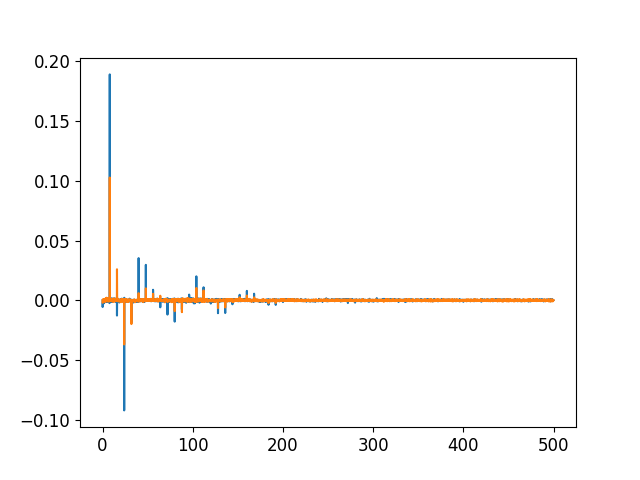

In [23]:
plt.figure()
plt.plot(f[:len(f)//2],fourier[:len(f)//2])
plt.plot(f_small[:len(f_small)//2],fourier_small[:len(f_small)//2])
plt.show()

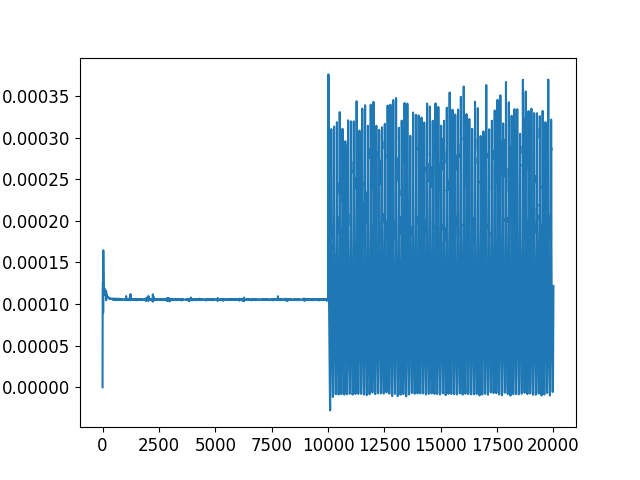

In [19]:
plt.figure()
for i in np.arange(6,7):
    plt.plot(totalSignal[i])

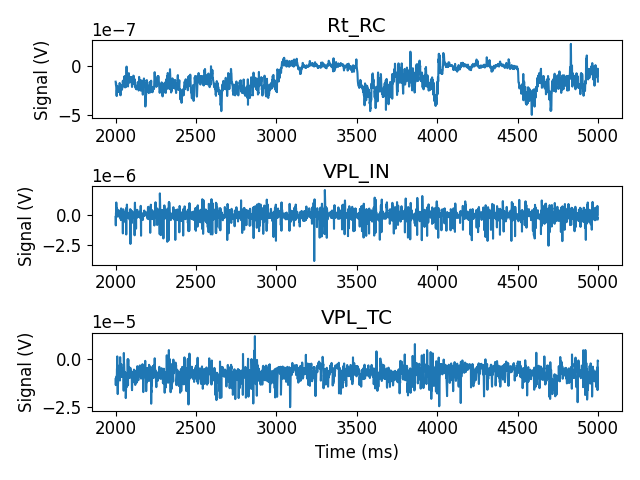

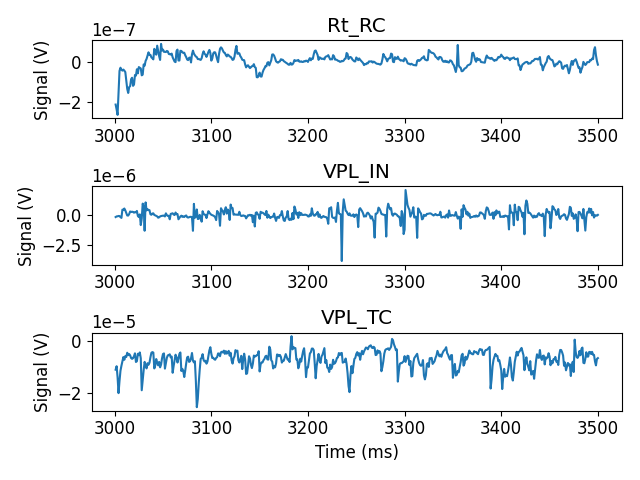

In [18]:
plt.figure()

plt.subplot(3,1,1)
plt.plot(p['Electrode'])
plt.ylabel('Signal (V)')
plt.title('Rt_RC')

plt.subplot(3,1,2)
plt.plot(p1['Electrode'])
plt.ylabel('Signal (V)')
plt.title('VPL_IN')

plt.subplot(3,1,3)
plt.plot(p2['Electrode'])
plt.ylabel('Signal (V)')
plt.title('VPL_TC')

plt.xlabel('Time (ms)')
plt.tight_layout()

plt.figure()

plt.subplot(3,1,1)
plt.plot(p['Electrode'].loc[3000:3500])
plt.ylabel('Signal (V)')
plt.title('Rt_RC')

plt.subplot(3,1,2)
plt.plot(p1['Electrode'].loc[3000:3500])
plt.ylabel('Signal (V)')
plt.title('VPL_IN')

plt.subplot(3,1,3)
plt.plot(p2['Electrode'].loc[3000:3500])
plt.ylabel('Signal (V)')
plt.title('VPL_TC')

plt.xlabel('Time (ms)')
plt.tight_layout()

# plt.plot(p1['Electrode'])
# plt.plot(p2['Electrode'])

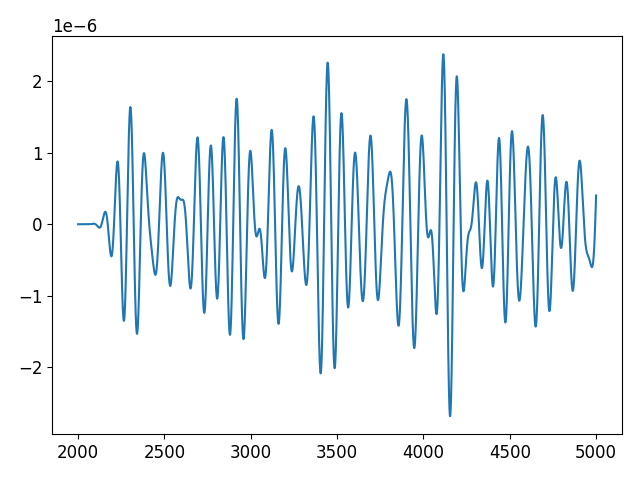

In [23]:
from scipy import signal
sos = signal.butter(10, [9,16], 'bp', fs=1000, output='sos')

filtered = signal.sosfilt(sos, p2['Electrode'])
time = np.linspace(2000,5000,3000)
plt.figure()
plt.plot(time,filtered)
plt.tight_layout()

# Samples cells from exemplary regions and gets scaling factors

In [5]:
circuit = s.circuit

In [6]:
nodes = circuit.nodes

In [7]:
import h5py

In [8]:
# Loads the weights file

coeffsFile = "../electrodeFile/coeffs.h5"

coeffs = h5py.File(coeffsFile)

In [9]:
# Node ids from weights file
allNodeIds = coeffs['thalamus_neurons']['node_ids']

In [10]:
np.random.seed(2643)

indices = np.sort(np.random.choice(np.arange(len(allNodeIds[:])),10,replace=False))


In [57]:
offsets = [coeffs['thalamus_neurons']['offsets'][:][indices],coeffs['thalamus_neurons']['offsets'][:][indices+1]]


In [58]:
# Gets compartment weights for the selected nodes (shifted such that the minimum weight for each neuron is 0)

scaleFac = []

for i in range(len(offsets[0])):
    
    s = coeffs['electrodes']['thalamus_neurons']['scaling_factors'][offsets[0][i]:offsets[1][i]][:,1]
    s -= np.min(s)

    scaleFac.append(s)



# Loads 3d positions

In [59]:
path_to_positions = "../data/getPositions/positions_all_new/"


In [60]:
# Loads positions for a subset of the selected nodes

allIds = allNodeIds[indices]

allIds = np.array(allIds)

import os

i = 0

for subfolder in os.listdir(path_to_positions):
    for file in os.listdir(path_to_positions+subfolder):
        
        if i > 10:
            break
        
        positions = pd.read_pickle(path_to_positions+subfolder+'/'+file)
        
        columns = np.array(list(positions.columns))[:,0]
        
        indices = np.where(np.isin(allIds,columns))[0]
        
        if len(indices)==0:
            continue
        
        idsInFile = allIds[indices]

        positions = positions[idsInFile]
        
        if i == 0:
            allPositions = positions
        else:
            allPositions = pd.concat((allPositions,positions),axis=1)
            
        i += 1
        

In [61]:
selectedIds = np.unique(np.array(list(allPositions.columns))[:,0])

In [62]:
def getNeuronSegmentMidpts(position):
    '''
    Gets midpoints for a single neuron
    '''

    
    secIds = np.array(list(position.columns))
    uniqueSecIds = np.unique(secIds)

    for sId in uniqueSecIds: # Iterates through sections

        pos = position.iloc[:,np.where(sId == secIds)[0]]

        if sId == 0: # Implies that section is a soma, so we just take the position from the file

            newPos = pos
 
        elif np.shape(pos.values)[-1] == 1: # If there is only one point in the section, we just take the value
            newPos = pd.concat((newPos,pos),axis=1)

        else: # We take the midpoints of the values in the file, which are the endpoints of the segments
            pos = (pos.iloc[:,:-1]+pos.iloc[:,1:])/2

            newPos = pd.concat((newPos,pos),axis=1)

    return newPos

In [63]:
# Spatial positions of the electrodes

lfp = np.array([200,200,800])

In [64]:
s = bp.Simulation('../data/simulation/simulation_config.json')
r = s.reports['compartment_2']


In [65]:
allPositions

id             38143                                                      \
section         0            1            1            1            1      
0         422.276611   422.276611   419.439118   416.601624   413.764131   
1         251.998398   251.998398   257.155932   262.313466   267.471000   
2        1164.849121  1164.849121  1166.010358  1167.171596  1168.332833   

id                                                                        ...  \
section         1            1            2            2            2     ...   
0         410.926637   408.089143   426.844484   432.189388   437.534292  ...   
1         272.628534   277.786068   261.170798   259.683298   258.195797  ...   
2        1169.494071  1170.655308  1161.015028  1158.730440  1156.445852  ...   

id            37520                                                  \
section        1051        1051        1051        1051        1052   
0        362.877368  350.951446  344.681605  339.527169  387.630965   
1        353.778779  343.015541  327.454009  310.875046  401.990248   
2        693.876844  702.027230  709.659943  715.476684  653.869302   

id                                                                   
section        1052        1052        1052        1052        1052  
0        383.412601  370.741186  362.425462  353.808457  343.806301  
1        421.169533  435.134302  447.612648  464.522090  478.494545  
2        653.927326  648.517565  636.022840  636.266097  631.104378  

[3 rows x 4746 columns]

In [66]:
d = r['thalamus_neurons'].get(38143)

In [67]:
d[38143]

,0,1,1,1,1,1,2,2,2,2,...,914,914,914,914,914,914,914,914,914,914
0.0,-65.000000,-65.000000,-65.000000,-65.000000,-65.000000,-65.000000,-65.000000,-65.000000,-65.000000,-65.000000,...,-65.000000,-65.000000,-65.000000,-65.000000,-65.000000,-65.000000,-65.000000,-65.000000,-65.000000,-65.000000
0.1,-65.054749,-65.054688,-65.054596,-65.054512,-65.054436,-65.054367,-65.054306,-65.054260,-65.054222,-65.054199,...,-65.050934,-65.050217,-65.049828,-65.049644,-65.049515,-65.049416,-65.049355,-65.049332,-65.049324,-65.049316
0.2,-65.106071,-65.106094,-65.106125,-65.106155,-65.106178,-65.106194,-65.106209,-65.106216,-65.106232,-65.106232,...,-65.101555,-65.100487,-65.099815,-65.099442,-65.099106,-65.098793,-65.098534,-65.098434,-65.098396,-65.098351
0.3,-65.156319,-65.156372,-65.156464,-65.156540,-65.156609,-65.156670,-65.156715,-65.156754,-65.156784,-65.156799,...,-65.151543,-65.150322,-65.149506,-65.149010,-65.148529,-65.148018,-65.147537,-65.147324,-65.147240,-65.147133
0.4,-65.205864,-65.205948,-65.206070,-65.206177,-65.206268,-65.206352,-65.206421,-65.206474,-65.206512,-65.206535,...,-65.200989,-65.199692,-65.198799,-65.198227,-65.197639,-65.196968,-65.196297,-65.195999,-65.195869,-65.195694
0.5,-65.254875,-65.254967,-65.255112,-65.255241,-65.255356,-65.255455,-65.255531,-65.255600,-65.255646,-65.255676,...,-65.249969,-65.248627,-65.247688,-65.247063,-65.246414,-65.245628,-65.244804,-65.244431,-65.244270,-65.244041
0.6,-65.303650,-65.303741,-65.303886,-65.304016,-65.304131,-65.304230,-65.304314,-65.304382,-65.304428,-65.304459,...,-65.298569,-65.297188,-65.296204,-65.295547,-65.294838,-65.293968,-65.293045,-65.292610,-65.292419,-65.292152
0.7,-65.352249,-65.352341,-65.352493,-65.352623,-65.352737,-65.352837,-65.352921,-65.352989,-65.353035,-65.353073,...,-65.346901,-65.345444,-65.344406,-65.343712,-65.342957,-65.342018,-65.341003,-65.340530,-65.340317,-65.340019
0.8,-65.400597,-65.400696,-65.400848,-65.400986,-65.401108,-65.401215,-65.401299,-65.401367,-65.401413,-65.401451,...,-65.394974,-65.393433,-65.392342,-65.391602,-65.390793,-65.389786,-65.388695,-65.388184,-65.387955,-65.387627
0.9,-65.448685,-65.448792,-65.448952,-65.449089,-65.449219,-65.449326,-65.449409,-65.449486,-65.449539,-65.449570,...,-65.442780,-65.441162,-65.440002,-65.439217,-65.438370,-65.437294,-65.436127,-65.435577,-65.435341,-65.434982


In [68]:
list(allPositions[38143].columns)

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 780,
 780,
 781,
 781,
 781,
 781,
 781,
 781,
 781,
 781,
 782,
 782,
 783,
 783,
 783,
 783,
 783,
 783,
 783,
 783,
 784,
 784,
 784,
 784,
 784,
 784,
 785,
 785,
 786,
 786,
 787,
 787,
 788,
 788,
 789,
 789,
 789,
 789,
 790,
 790,
 790,
 790,
 791,
 791,
 791,
 791,
 791,
 791,
 791,
 791,
 792,
 792,
 792,
 792,
 793,
 793,
 793,
 793,
 793,
 793,
 793,
 793,
 794,
 794,
 795,
 795,
 796,
 796,
 796,
 796,
 796,
 796,
 797,
 797,
 797,
 797,
 797,
 797,
 798,
 798,
 798,
 798,
 798,
 798,
 798,
 798,
 798,
 798,
 799,
 799,
 800,
 800,
 801,
 801,
 802,
 802,
 802,
 802,
 802,
 802,
 802,
 802,
 802,
 802,
 803,
 803,
 803,
 803,
 803,
 803,
 803,
 803,
 804,
 804,
 804,
 804,
 804,
 804,
 805,
 805,
 805,
 805,
 805,
 805,
 806,
 806,
 807,
 807,
 808,
 808,
 809,
 809,
 810,
 810,
 811,
 811,
 811,
 811,
 811,
 811,
 812,
 812,
 812,
 812,
 812,
 812,
 813,
 813,
 813,
 813,
 813,
 813,
 813,
 813,
 813,
 813,
 814,
 814,


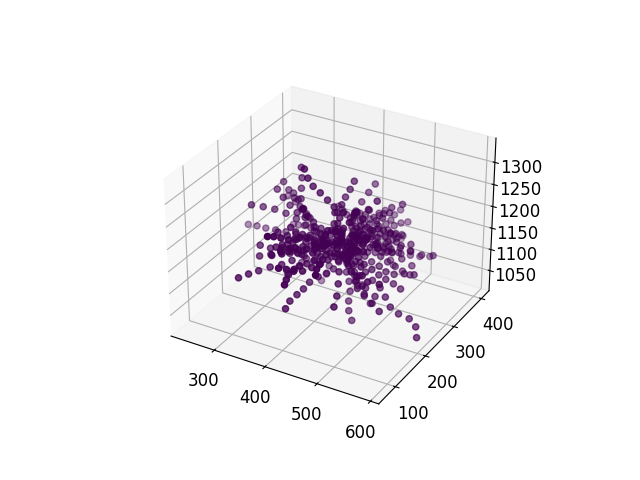

In [69]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

for i in [38143]:
    p = getNeuronSegmentMidpts(allPositions[i]).values
    
    index = np.where(allIds==i)[0][0]
    
    scale = scaleFac[index]
    
    im = ax.scatter(p[0],p[1],p[2],c=scale)

In [70]:
from morphio import Morphology

In [71]:
from bluerecording.utils import *

In [72]:
def get_morph_path(population, i, path_to_simconfig):
    
    morphName = population.get(i, 'morphology') # Gets name of the morphology file for node_id i

    circuitpath = getCircuitPath(path_to_simconfig) # path to circuit_config file

    with open(circuitpath) as f: # Gets path to morphology file from circuit_config

        js = json.load(f)

        if 'components' in js.keys() and 'morphologies_dir' in js['components'].keys() and '$MORPHOLOGIES' not in js['components']['morphologies_dir']:
                finalmorphpath = js['components']['morphologies_dir'] + '/morphologies'
    
        else:
    
            basedir = js['manifest']['$BASE_DIR']
            morphpath = js['manifest']['$MORPHOLOGIES']
            finalmorphpath = basedir
            for m in morphpath.split('/')[1:]:
                finalmorphpath = finalmorphpath + '/'+m

    if os.path.exists(finalmorphpath+'/ascii/'):
        fileName = finalmorphpath+'/ascii/'+morphName+'.asc'
    else:
        fileName = finalmorphpath+'/morphologies_asc/'+morphName+'.asc'
    
    return fileName

In [73]:
def getMorphology(population, i, path_to_simconfig):


    finalmorphpath = get_morph_path(population, i, path_to_simconfig)

    mImmutable = Morphology(finalmorphpath) # Immutable MorphIO morphology object

    m = MutableMorph(mImmutable) # Mutable version, so that we can change the positions to orient the cell correctly within the circuit

    m, center = positionMorphology(m, population, i)

    return m, center

In [74]:
pop = getPopulationObject('../data/simulation/simulation_config.json')

In [75]:
from scipy.spatial.transform import Rotation as R

In [76]:
m = get_morph_path(pop,38143,'../data/simulation/simulation_config.json')

In [77]:
class MutableMorph():

    '''
    This class defines a version of the morphIO morphology object that is both mutable and contains all of the data of the immutable object
    '''

    def __init__(self,morphioMorph):

        for attr in dir(morphioMorph):
            if '__' not in attr:
                setattr(self,attr,getattr(morphioMorph,attr))

        #### self.indices is a list of lists, where self.indices[i] is a list containing the indices of the 3d points for the ith section. The soma is not included because it is not part of morphioImmutableObject.sections
        self.indices = []
        index = 0
        for section in self.sections:
            self.indices.append([])

            for i in range(len(section.points)):
                self.indices[-1].append(index)
                index += 1

In [78]:
def get_transform(population, i):

    center = np.array([population.get(group=[i],properties='x'),population.get(group=[i],properties='y'),population.get(group=[i],properties='z')]) # Gets soma position

    center = center.flatten()

    ### Gets orientation of the cell in the circuit
    rotW = population.get(group=[i],properties='orientation_w')
    rotX = population.get(group=[i],properties='orientation_x')
    rotY = population.get(group=[i],properties='orientation_y')
    rotZ = population.get(group=[i],properties='orientation_z')
    ####

    ### Creates rotation quaternion for cell
    rotQuat = np.array([rotX,rotY,rotZ,rotW])
    rotQuat /= np.linalg.norm(rotQuat)
    rotation = R.from_quat(rotQuat.flatten())
    ###

    return center, rotation

In [79]:
def apply_transform(m, center, rotation):

    m.points = R.apply(rotation,m.points) # Rotates cell

    m.points += center # Translates cell

    return m

In [80]:
def positionMorphology(m, population, i):

    center, rotation = get_transform(population, i)

    m = apply_transform(m, center, rotation)

    return m, center


In [81]:
morph = Morphology(m)

In [82]:
newM = getMorphology(pop,38143,'../data/simulation/simulation_config.json')[0]

In [83]:
report, nodeIds = getSimulationInfo('../data/simulation/simulation_config.json')

In [84]:
sscx = pd.read_pickle('../../SSCx/data/getPositions/positions_all_new/0/positions0.pkl')

In [85]:
np.array(sscx[0].columns)

array([  0,   1,   1,   1,   1,   1,   1,   2,   2,   2,   2,   2,   2,
       134, 134, 135, 135, 135, 135, 135, 135, 136, 136, 136, 136, 136,
       136, 137, 137, 137, 137, 137, 137, 137, 137, 138, 138, 139, 139,
       140, 140, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141,
       141, 141, 141, 142, 142, 143, 143, 144, 144, 145, 145, 146, 146,
       146, 146, 146, 146, 146, 146, 147, 147, 148, 148, 148, 148, 148,
       148, 149, 149, 149, 149, 149, 149, 150, 150, 150, 150, 150, 150,
       150, 150, 150, 150, 151, 151, 152, 152, 153, 153, 154, 154, 154,
       154, 154, 154, 154, 154, 155, 155, 155, 155, 155, 155, 156, 156,
       156, 156, 157, 157, 158, 158, 158, 158, 159, 159, 159, 159, 159,
       159, 159, 159, 160, 160, 161, 161, 161, 161, 161, 161, 161, 161,
       162, 162, 162, 162, 162, 162, 162, 162, 163, 163, 164, 164, 165,
       165, 166, 166, 166, 166, 167, 167, 167, 167, 167, 167, 168, 168,
       169, 169, 169, 169, 169, 169, 170, 170, 170, 170, 171, 17

In [86]:
data = getMinimalReport(report,[38143])

 2024-07-12 15:34:03,488: dt from the report differs from the global simulation dt.


In [87]:
colIdx = data.columns

In [88]:
cols = np.array(list(data.columns))

In [89]:
newM.sections[3].type==3

True

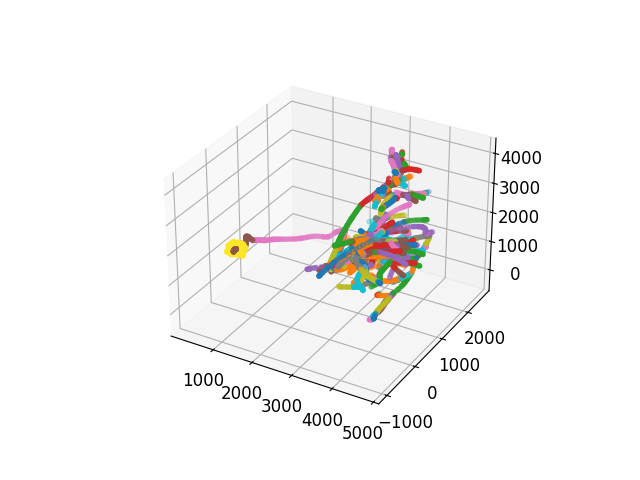

In [91]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
# ax.scatter(newM.points[:,0],newM.points[:,1],newM.points[:,2],s=0.5)


for i in [38143]:
    p = allPositions[i]
    
    index = np.where(allIds==i)[0][0]
    
    scale = scaleFac[index]

    colors = np.array(p.columns)

    colors[colors<3] = 0
    colors[colors>3] =1
    
    im = ax.scatter(p.values[0],p.values[1],p.values[2],c=colors)

for idx in newM.indices[:780]:
    ax.scatter(newM.points[idx,0],newM.points[idx,1],newM.points[idx,2],s=10)
    
plt.show()

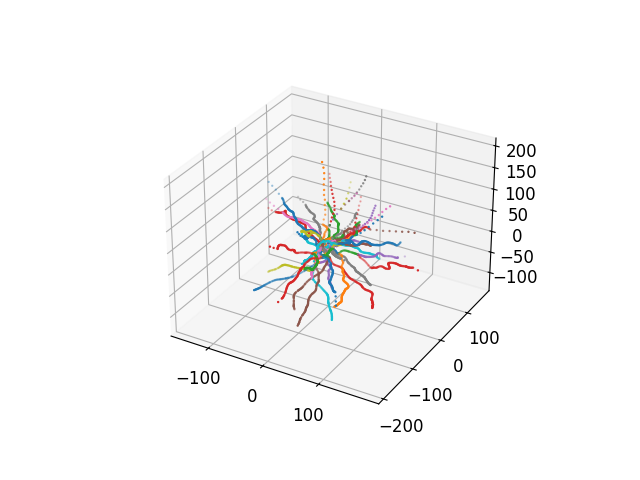

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
# ax.scatter(morph.points[:,0],morph.points[:,1],morph.points[:,2])
for sec in morph.sections[:100]:
    ax.scatter(sec.points[:,0],sec.points[:,1],sec.points[:,2],s=0.5)


In [46]:
numS = 0
for s in morph.sections:
    if s.type==3:
        numS += 1
print(numS)

135


In [73]:
len(np.unique(list(p.columns)))

138

In [75]:
s.type == 2

True